# Policy search with linear function approximation

## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install q tensorflow==1.15
!pip install q keras==2.2.4

In [3]:
# The basics
%matplotlib inline
import numpy as np
import sys
import os
import random
from collections import namedtuple
import collections
import copy
from mpl_toolkits.mplot3d import Axes3D

os.chdir('..')

import virl
import utils

import matplotlib.pyplot as plt
import time
import itertools
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from collections import deque

from collections import namedtuple

# basic tools for defining the function and doing the gradient-based learning
import sklearn.pipeline
import sklearn.preprocessing

# RBF function transformation method
from sklearn.kernel_approximation import RBFSampler
# to solve the optimisaiton with gradient based optimiser
from sklearn.linear_model import SGDRegressor # this defines the SGD function
# Tensorflow for reinforcement
import tensorflow as tf



# Policy stuff
import keras
import pandas as pd
from keras.models import Sequential
#from keras.layers import Dense
from keras.optimizers import Adam
#from keras import backend as K

from keras import layers
from keras.models import Model
from keras import backend as K
from keras import utils as np_utils
from keras import optimizers
from keras import initializers

import tensorflow as tf

from gym.envs.toy_text import discrete

print(sys.version)

3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]


Using TensorFlow backend.


# Analysis

In [ ]:
## performance defined by rewards

## 4?5 States s(t):
# s[0]: susceptible people
# s[1]: infectious people
# s[2]: quarantined people
# s[4]: recovered people

# what is mystery state s[3]? - need to find out lol

## 4 Actions a(t):
# 0: none - do nothing
# 1: impose full lockdown
# 2: implement track & trace
# 3: social distancing - enforce masks, and distancing

## Every week agent obtain evidence of state of pandemic
## and should update policies accordingly
## each episode ends after 52 weeks

## 10 deterministic epidemic problems, each with different set of parameters
## Assuming stochasticity is false;
## specific problem with problem_id=x, x in [0..9], default 0.

## Environment

environment based on https://git.dcs.gla.ac.uk/SebastianStein/virl

In [17]:
env = virl.Epidemic(stochastic=False, noisy=False)
"""
Args:
    stochastic (bool): Is the infection rate sampled from some distribution at the beginning of each episode (default: False)?
    noisy (bool): Is the state a noisy estimate of the true state (default: False)?
    problem_id (int): Deterministic parameterization of the epidemic (default: 0).
"""

states = []
rewards = []
done = False


# observations of the states, and actions we can expect
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

print(env.action_space)
print(env.observation_space)
print(observation_examples)

4
Box(0.0, inf, (4,), float64)
[[0.04593028 2.76495059 0.54184618 1.59930159]
 [0.427085   2.14685174 0.04349968 2.11459319]
 [0.43470758 2.81515669 0.5936897  0.0689046 ]
 ...
 [0.08768255 1.365196   2.5770891  1.01453647]
 [0.95079847 0.20929133 1.72633482 0.42306737]
 [0.24226572 1.5919201  0.55681976 2.0982558 ]]


### Policy Function

we want to be able to define a policy from the Q(s,a) function

In [52]:
def create_policy(func_approximator, epsilon, num_actions):
    """
    Takes as argument observations, return a policy for best action to perform.
    This function creates a greedy policy with the exploration defined by the epsilon, and num_actions parameters
    
    args:
        func_approximator: the probability Q(s,a) given a state s
        epsilon: probability to select a random action (float between 0, and 1)
        num_actions: number of actions in environement
    
    return:
        a policy function; action to perform
    
    """
    def policy_fn(state):
        """
        Takes a state, and returns potential stochastic policy from exploration.
        
        args:
            state: a 2D array of given state(s)
        return:
            a pair {A,q_values} 
                A: list of scores for each action
                q_values: value returned by approximator
        """
        A = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = func_approximator.predict(state)
        best_action = np.argmax(q_values)
        # if epsilon is low, "best" action will be reinforced
        A[best_action] += (1.0 - epsilon)
        return A,q_values

    return policy_fn

----

## Random Simulation

s = env.reset()
states.append(s)
while not done:
    s, r, done, i = env.step(action=2) # deterministic agent
    #s, r, done, i = env.step(action=np.random.choice(env.action_space.n))
    states.append(s)
    rewards.append(r)

----

## Function Approximator

radial basis function (RBF) whose value depends only on the distance between the input and some fixed function $\phi$.

$${f}({\mathbf{x}}) = \sum\limits_j^{} {{w_j}{\phi _j}\left( s \right)}  = \sum\limits_j^{} {\left( {{w_j} \cdot \exp \left( { - \tfrac{1}{{{\gamma_j^2}}}\left\| {{\mathbf{x}} - {{\boldsymbol{\mu }}_j}} \right\|}_2^2 \right)} \right)} $$



if we take action $a$ in state $s$ and observe that we end up in$ s'$, and we assume that this happends all the time, then the Bellman equations reduces to a very simple form.

$$Q(s,a) = R(s) + \gamma {\max _{a'}}Q(s',a')$$

for the function approx, we can instead formulate the problem as a least squares problem i.e. try to minimize the distance between the just observed transition leading to the td-target:

$$Q(s,a) \leftarrow Q(s,a) + \alpha ( R(s) + \gamma {\max _{a'}}Q(s',a') - Q(s,a) )$$

which is just,
$$w^* = argmin_w (R(s) + \gamma {\max _{a'}}\hat Q_w(s',a') - \hat Q_w(s,a) )^2$$

this allows us to do an update based on the single observation of what happend in state $s$ taking action $a$. This can be done by computing the gradient of the loss w.r.t. $w$, and making a small update to the weights. Since this is only based on one observation and there is some uncertanty to it we call it a online/stochastic gradient

### Defining model for Q(s,a)

In [6]:
# consider if our input values are normalised; zero mean, and one standard deviation for input.

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

StandardScaler()

#### our exp()

$${\left( { \exp \left( { - \tfrac{1}{{{\gamma_j^2}}}\left\| {{\mathbf{x}} - {{\boldsymbol{\mu }}_j}} \right\|}_2^2 \right)} \right)} $$

In [7]:
# def rbf_func(x,mu,gamma):
#     return np.exp(- np.linalg.norm(x-mu,axis=-1)**2 / gamma**2)

# use sklearn to handle the RBF function in our agent for us
# define multiple RBF functions with random location, and scale: the 𝜇 (mu), and 𝛾 (gamma) respectively
feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

# state represented by our total n_components

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [8]:
s_scaled = scaler.transform([observation_examples[0]])
s_transformed = feature_transformer.transform(s_scaled)
print(np.shape(s_transformed))
print(s_scaled)

(1, 400)
[[ 2.52295769  0.08043792 -0.52640751 -0.75493645]]


###  Implementation of function approximator

uses separate functions for each action i.e. the action serves only as a selector for a set of three independent functions.
<br>
i.e. we could write $Q_{w_a}(s)$ to indicate that we have seperate functions with different parameter sets.

In [ ]:
?SGDRRegressor

In [71]:
class FunctionApproximator():
    """
    Approximates Q(s,a) with RBF

    """
 
    def __init__(self, eta0= 0.01, learning_rate= "constant"):
        """
        function approximator constructor set up
        
        args:
            eta0: (initial) learning rate
            learning_rate: (schedule) eta = eta0;
                gradient of loss estimated at each sample at a time, and model to update along the way with a decreasing strength schedule
        """

        self.eta0=eta0
        self.learning_rate=learning_rate
        
        self.models = []
        for _ in range(env.action_space.n):
            
            # tol: float, default=1e-3; stopping criterion. If it is not None, training will stop when (loss > best_loss - tol)
            # max_iter: float; maximum number of passes over the training data: epochs
            model = SGDRegressor(learning_rate=learning_rate, tol=1e-5, max_iter=1e5, eta0=eta0)
            
            # to perform training, we must fit data or we will get error
            # a hacky approach or something
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        returns the featurized representation for a state.
        """
        s_scaled = scaler.transform([state])
        s_transformed = feature_transformer.transform(s_scaled)
        return s_transformed[0]
    
    def predict(self, s, a=None):
        """
        makes Q(s,a) function predictions
        
        args:
            s: state to make a prediction for
            a: (optional) action to make a prediction for
            
        returns
            given 'a', return a single number as the prediction
            else, return a vector or predictions for all actions in the environment where pred[i] is the prediction for action i.
        """
        
        features = self.featurize_state(s)
        if a==None:
            return np.array([m.predict([features])[0] for m in self.models])
        else:            
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, td_target):
        """
        updates the approximator's parameters (i.e. the weights) for a given state and action towards
        the target y (which is the TD target).
        """
        
        features = self.featurize_state(s)
        # we have a seperate function for each 'a'
        self.models[a].partial_fit([features], [td_target])
    
    def new_episode(self):        
        self.t_episode  = 0. 

### Policy Search

In [54]:
# to be able to do stats checking after
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

In [57]:
def reinforce(env, estimator_policy, num_episodes, discount_factor=1.0, eta0=0.01):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized         
        num_episodes: Number of episodes to run for
        discount_factor: reward discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    
    Adapted from: https://github.com/dennybritz/reinforcement-learning/blob/master/PolicyGradient/CliffWalk%20REINFORCE%20with%20Baseline%20Solution.ipynb
    """

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    np.random.seed(1)
    
    # init weight
    # w = np.random.rand(400,2)
    # grads = []
    
    # for however many episodes until convergence
    for i_episode in range(num_episodes):
        epsilon=0.1
        epsilon_decay=1.0       
        # Create a handle to the policy we're following (including exploration)
        policy = create_policy(
            estimator_policy, epsilon * epsilon_decay**i_episode, env.action_space.n)
        # Print out which episode we're on, useful for debugging
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # state = estimator_policy.featurize_state(state)
        
        # to store entire episode
        episode = []
        
        # One step in the environment; generate a full episode by following current policy
        for t in itertools.count():
                        
            # Choose an action to take                        
            # action_probs = np.exp(state.dot(w))/np.sum(np.exp(state.dot(w)))
            action_probs, q_vals = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            
            # compute gradient and save with rewards for weight update
            # s = action_probs.reshape(-1,1)
            # dsoftmax = np.diagflat(s) - np.dot(s, s.T)[action,:]
            # dlog = dsoftmax / action_probs[action]
            # grad = state.T.dot(dlog[None,:])
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            # grads.append(grad)
            
            # TD update
            q_values_next = estimator_policy.predict(next_state)
            
            # TD target
            td_target = reward + discount_factor * np.max(q_values_next)
              
            # Update the function approximator using our target
            estimator_policy.update(state, action, td_target)
            
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")         
                
            if done:
                break
                
            state = next_state
            
        # weight update
        # for i in range(len(grads)):
            # loop through episode, update towards policy_gradient * future_rewards
        #    w += eta0 * grads[i] * sum([r * (discount_factor ** r) for t,r in enumerate(rewards[i:])])
    
        # Go through the episode, step-by-step and make policy updates (note we sometime use j for the individual steps)
        estimator_policy.new_episode()
        new_theta=[]
        for t, transition in enumerate(episode):                 
            #     sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            # The return, G_t, after this timestep; this is the target for the PolicyEstimator
            G_t = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
           
            # Update our policy estimator
            estimator_policy.update(state, transition.action,np.array(G_t))            
         
    return stats

### Training Agent

Step 51 @ Episode 100/100 (-1.6929764051941052)

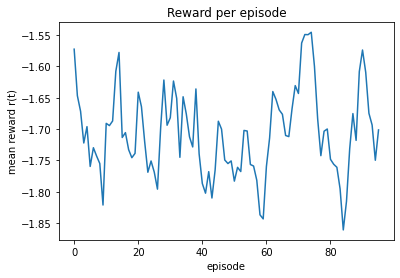

In [58]:
## RBF Policy Search
approximator_dl = FunctionApproximator(eta0=0.01)
stats = reinforce(env, approximator_dl, 100)
utils.plot_avg_reward(stats.episode_rewards)

# Display results

# Analysis

### Full evaluation without noise¶

In [ ]:
utils.evaluate(create_policy(approximator_dl, 0, 4), full_eval=True, verbose=False)

We perform cross-validation across all possible problems: we train on each problem  𝑖  and test on each problem  𝑗 .

We increase the number of epochs to 250 to highlight potential improvements.

Training on problem 0
Step 51 @ Episode 250/250 (-1.8592046261167992)

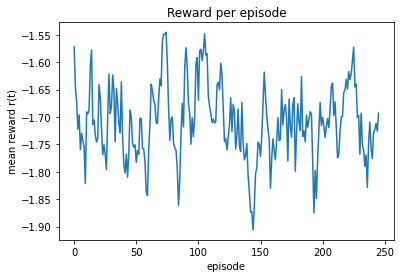

Training on problem 1
Step 51 @ Episode 250/250 (-0.4076873734238287))

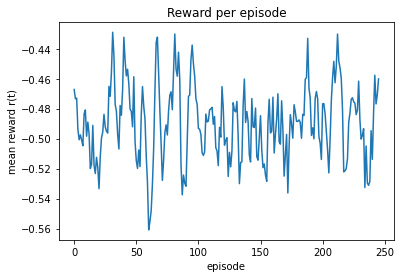

Training on problem 2
Step 51 @ Episode 250/250 (-0.9160505591022351)

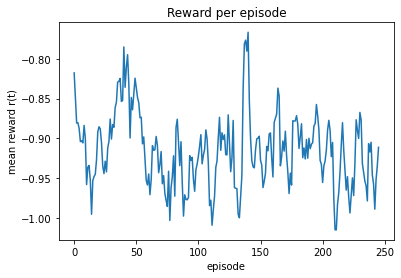

Training on problem 3
Step 51 @ Episode 250/250 (-1.217447588817281))

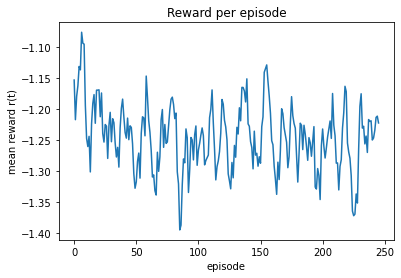

Training on problem 4
Step 51 @ Episode 250/250 (-1.8881513866126118)

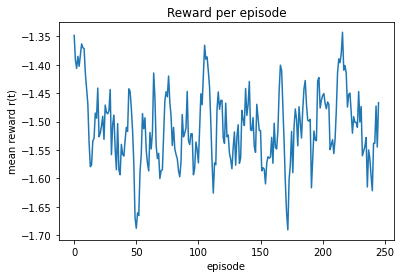

Training on problem 5
Step 51 @ Episode 250/250 (-1.8517684778371568)

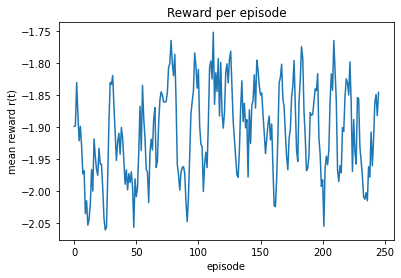

Training on problem 6
Step 51 @ Episode 250/250 (-1.938031539765439))

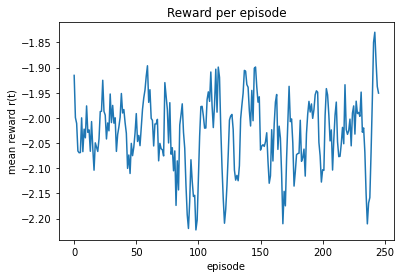

Training on problem 7
Step 51 @ Episode 250/250 (-1.9792262829616547)

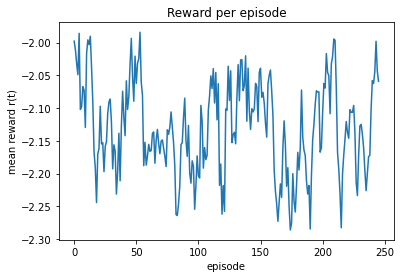

Training on problem 8
Step 51 @ Episode 250/250 (-2.2555332893488784)

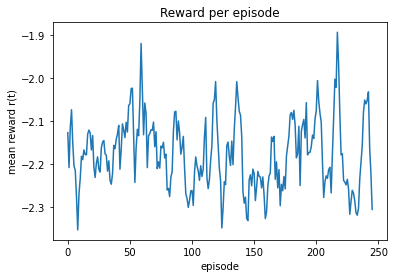

Training on problem 9
Step 51 @ Episode 250/250 (-2.231507949190697))

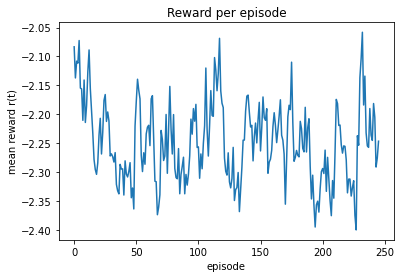

Trained on problem 0 & 1.88 & 0.32 & 0.76 & 1.11 & 1.64 & 1.79 & 2.07 & 2.11 & 2.36 & \textbf{1.96} & 1.6\\ 
Trained on problem 1 & 1.61 & \textbf{0.32} & 0.94 & 1.21 & 1.47 & 1.88 & 1.98 & 1.83 & 1.94 & 2.06 & 1.53\\ 
Trained on problem 2 & 1.72 & 0.74 & 1.19 & 1.52 & 1.86 & 1.91 & 1.75 & 1.96 & 2.18 & 2.09 & 1.69\\ 
Trained on problem 3 & 1.81 & 0.34 & 0.92 & 1.21 & 1.5 & 1.95 & 1.86 & 2.01 & 2.01 & 2.26 & 1.59\\ 
Trained on problem 4 & 1.86 & 0.4 & 1.0 & 1.09 & 1.51 & 1.93 & 1.86 & \textbf{1.8} & 2.2 & 2.13 & 1.58\\ 
Trained on problem 5 & 1.74 & 0.4 & 0.86 & 1.13 & 1.45 & 1.9 & 2.09 & 2.16 & \textbf{1.89} & 2.17 & 1.58\\ 
Trained on problem 6 & 1.76 & 0.38 & 1.28 & 1.45 & 1.65 & 2.04 & 1.91 & 1.93 & 2.19 & 2.35 & 1.7\\ 
Trained on problem 7 & 2.02 & 0.53 & 1.14 & 1.44 & 1.86 & \textbf{1.47} & \textbf{1.74} & 2.07 & 2.0 & 2.22 & 1.65\\ 
Trained on problem 8 & \textbf{1.53} & 0.44 & 0.54 & \textbf{0.91} & 1.53 & 1.87 & 2.07 & 1.99 & 1.95 & 2.18 & \textbf{\underline{1.5}}\\ 
Trained o

In [60]:
envs = [virl.Epidemic(problem_id=i) for i in range(10)]

full_rewards = []
policies = []

for i in range(10):
    print("Training on problem", i)
    env = envs[i]
    
    approximator_dl = FunctionApproximator(eta0=0.01)
    stats = reinforce(env, approximator_dl, 250)
    
    utils.plot_avg_reward(stats.episode_rewards)
    policy = create_policy(approximator_dl, 0, 4)
    policies.append(policy)
    plt.show()
    
    for j in range(10):
        states, rewards, actions = utils.execute_policy(policy, envs[j])
        full_rewards.append(-np.sum(rewards))

# To copy on the LaTex report
print(utils.latex_table(np.array(full_rewards).reshape(10, 10), [f"Trained on problem {i}" for i in range(10)], include_means=True))

In [61]:
envs = [virl.Epidemic(problem_id=i, noisy=True) for i in range(10)]

full_rewards_noisy = []

for i in range(10):
    for j in range(10):
        states, rewards, actions = utils.execute_policy(policies[i], envs[j])
        full_rewards_noisy.append(-np.sum(rewards))

# To copy on the LaTex report
print(utils.latex_table(np.array(full_rewards_noisy).reshape(10, 10), [f"Trained on problem {i}" for i in range(10)], include_means=True))

Trained on problem 0 & 1.48 & 0.47 & 0.56 & 1.36 & 1.71 & 2.01 & 1.84 & 1.95 & 2.34 & 2.24 & 1.6\\ 
Trained on problem 1 & 1.75 & 0.36 & 0.84 & 1.33 & 1.47 & 1.94 & 2.01 & 2.12 & 2.13 & 2.14 & 1.61\\ 
Trained on problem 2 & 1.81 & 0.37 & 1.34 & 1.32 & 1.56 & 1.76 & 1.98 & \textbf{1.89} & \textbf{2.06} & 2.07 & 1.62\\ 
Trained on problem 3 & 1.63 & 0.33 & 0.78 & 1.25 & 1.56 & 1.99 & 1.99 & 1.93 & 2.06 & 2.33 & 1.58\\ 
Trained on problem 4 & 1.67 & \textbf{0.32} & 0.6 & 1.3 & 1.59 & 2.12 & 2.07 & 2.09 & 2.2 & 2.25 & 1.62\\ 
Trained on problem 5 & 1.9 & 0.38 & 0.71 & 1.32 & 1.3 & 1.88 & 2.02 & 2.08 & 2.07 & 2.27 & 1.59\\ 
Trained on problem 6 & 1.7 & 0.42 & 0.89 & 1.51 & 1.7 & 1.81 & 2.03 & 2.24 & 2.13 & 2.31 & 1.67\\ 
Trained on problem 7 & 1.81 & 0.54 & 0.54 & 1.2 & 1.66 & 1.95 & \textbf{1.56} & 2.01 & 2.26 & \textbf{1.8} & 1.53\\ 
Trained on problem 8 & \textbf{1.39} & 0.53 & \textbf{0.54} & 1.06 & 1.53 & \textbf{1.52} & 1.84 & 2.18 & 2.08 & 2.19 & \textbf{\underline{1.49}}\\ 
Trained 

It would appear training on problem 8 gives the best result. So, we will use that as our main training set.

In [73]:
approximator_dl = policies[8]

# Full evaluation in noiseless environment

[-1.530297467112289,
 -0.4404541567525468,
 -0.5415707022056344,
 -0.9078149712623664,
 -1.5284773591583072,
 -1.8689148871881824,
 -2.073004288441367,
 -1.9931929458584547,
 -1.9538199924641735,
 -2.181269033545992]

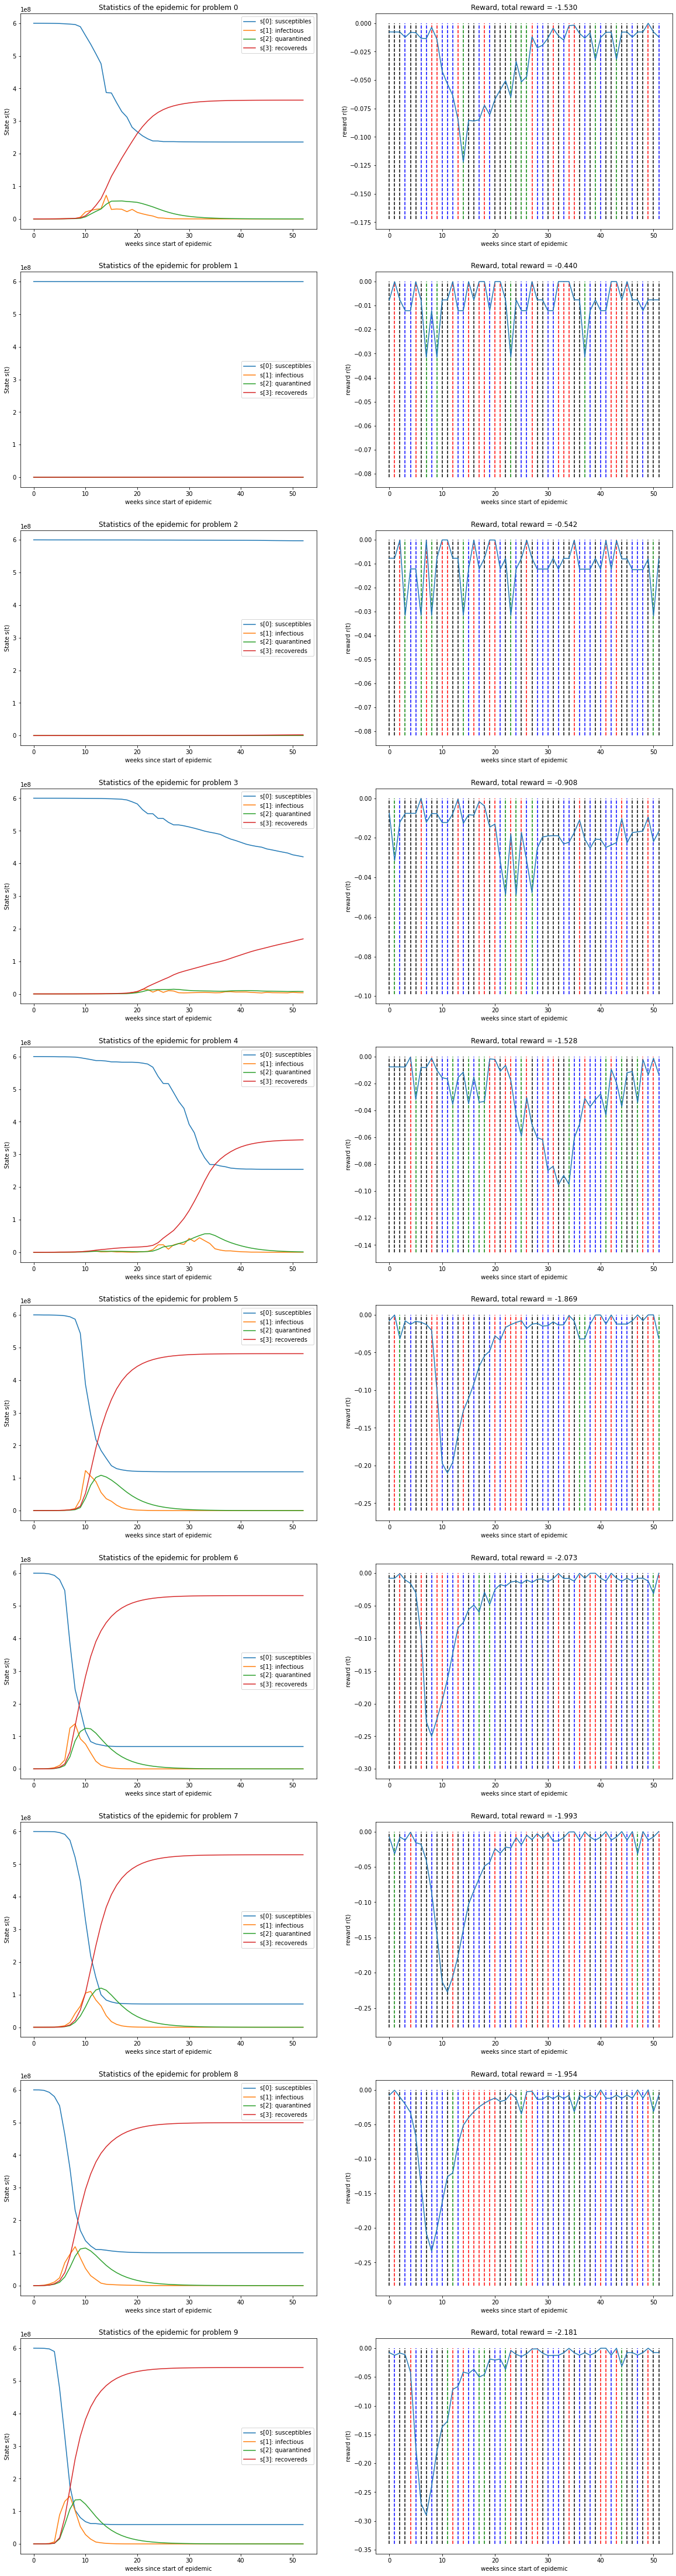

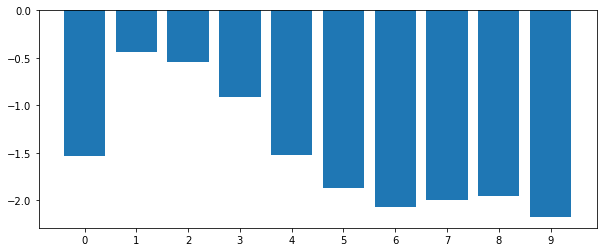

In [63]:
utils.evaluate(approximator_dl, full_eval=True, verbose=False)

### Full evaluation without noise

[-1.530297467112289,
 -0.4404541567525468,
 -0.5415707022056344,
 -0.9078149712623664,
 -1.5284773591583072,
 -1.8689148871881824,
 -2.073004288441367,
 -1.9931929458584547,
 -1.9538199924641735,
 -2.181269033545992]

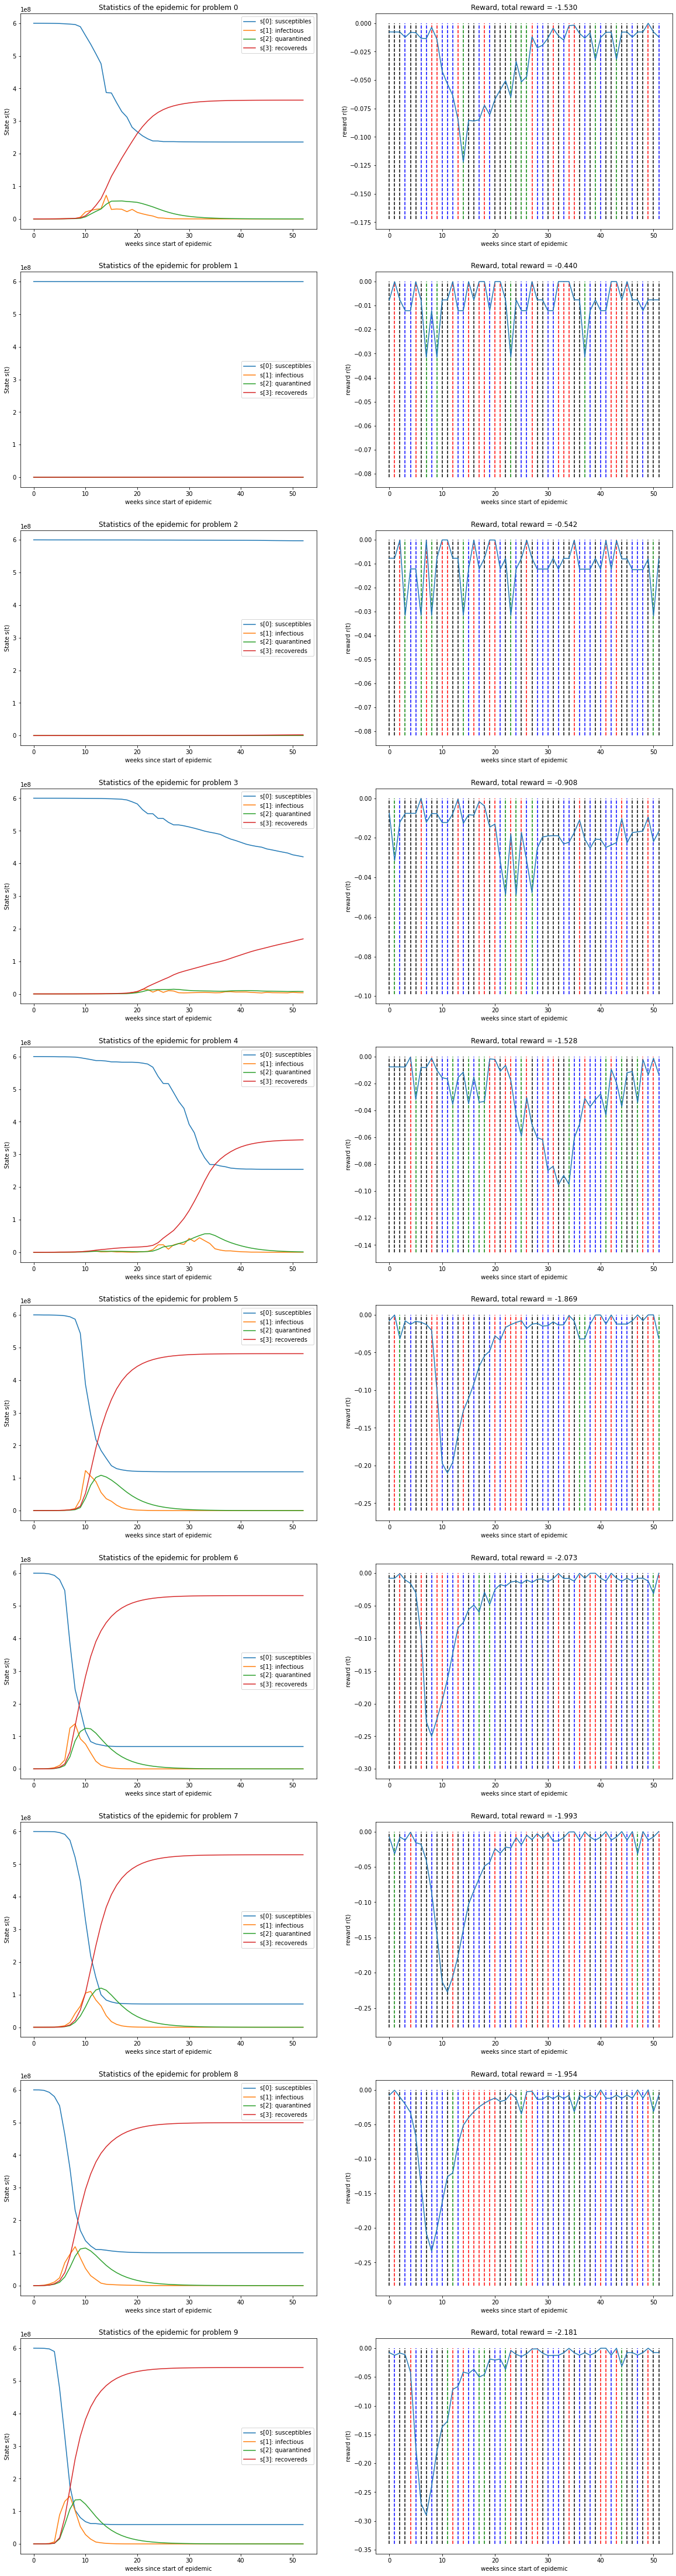

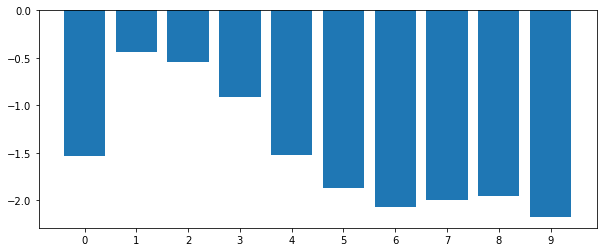

In [64]:
utils.evaluate(approximator_dl, full_eval=True, verbose=False)

### Full evaluation with noise

[-1.7510073325807007,
 -0.46413797637724186,
 -0.5111600024331795,
 -1.0854816933734466,
 -1.087257505981541,
 -1.7481473390946882,
 -1.9277347444927349,
 -2.1760307980710762,
 -2.241861729223702,
 -2.072072316011389]

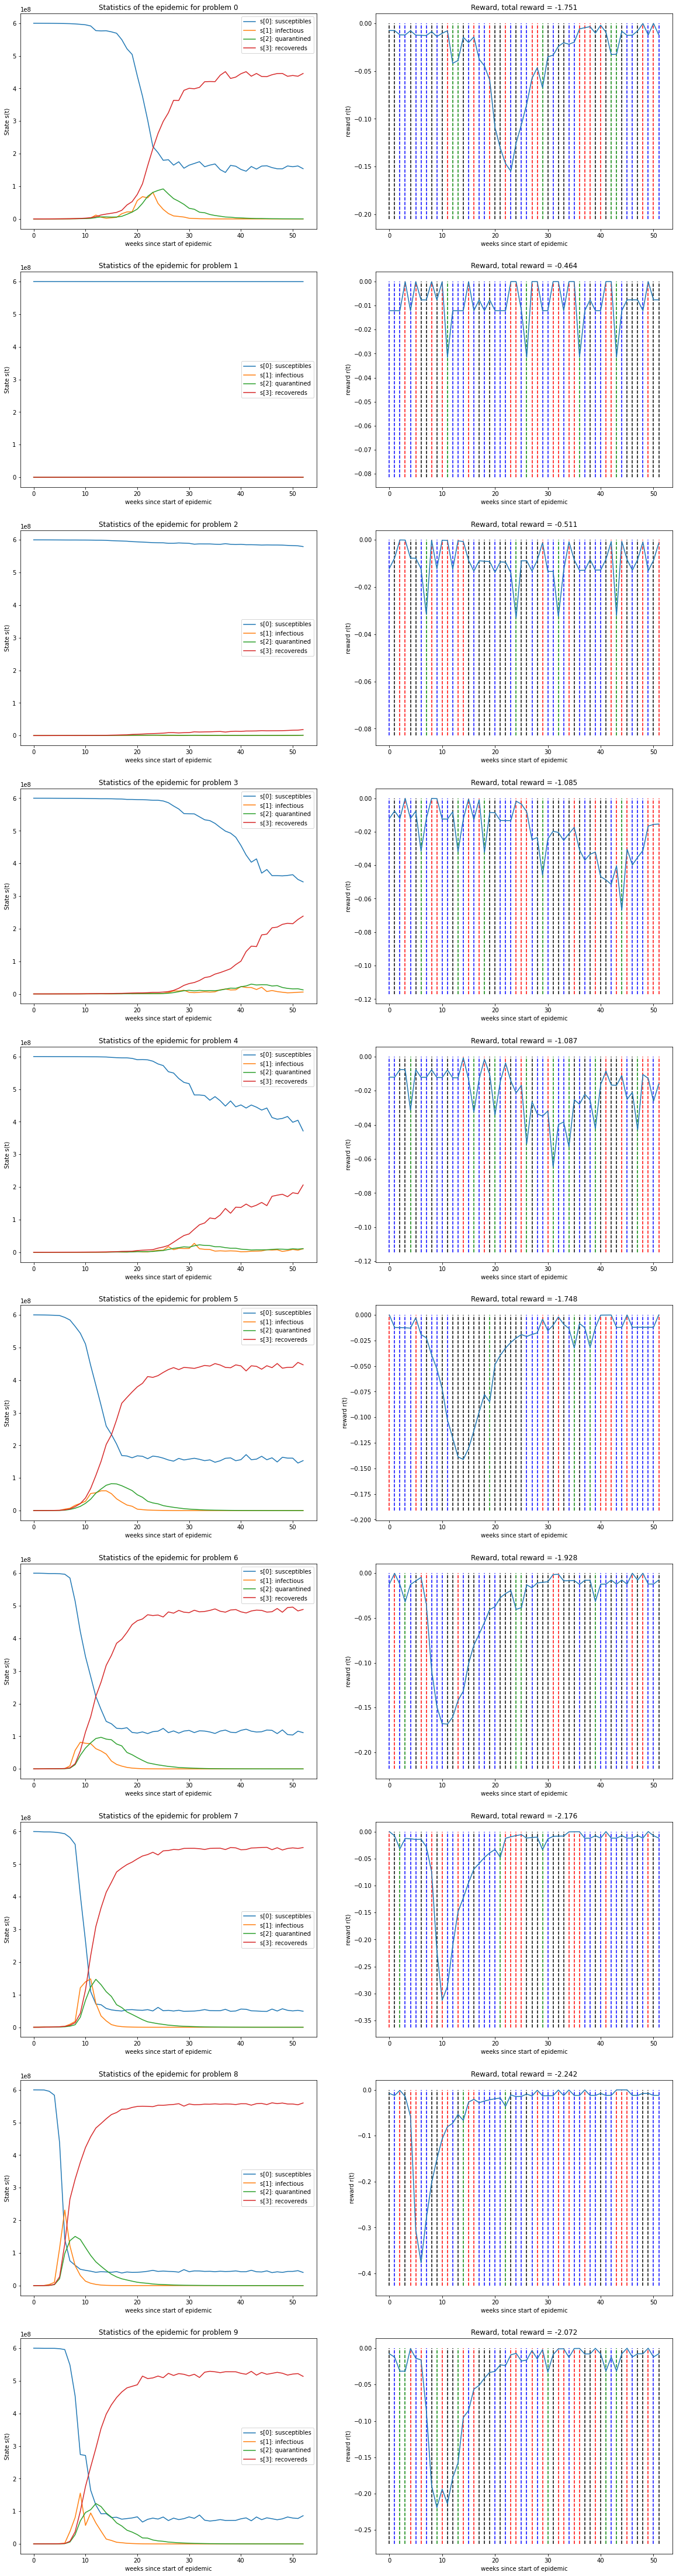

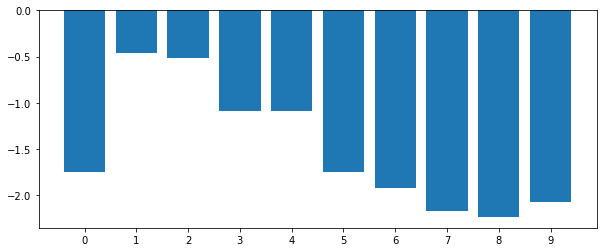

In [65]:
utils.evaluate(approximator_dl, full_eval=True, noisy=True, verbose=False)

### Stochastic analysis with noise

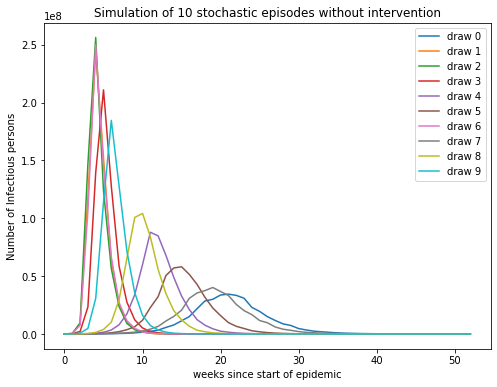

In [67]:
utils.evaluate_stochastic(create_policy(approximator_dl, 0, 4))

In [74]:
for i in range(10):
    env = virl.Epidemic(problem_id=i)
    diff, ratio = utils.regret_metric(approximator_dl, env=env)
    print(f"On problem {i}, regret is: {diff:.2f} (absolute) or {ratio * 100.0:.2f}% (relative)")

On problem 0, regret is: -0.65 (absolute) or -73.89% (relative)
On problem 1, regret is: -0.12 (absolute) or -38.57% (relative)
On problem 2, regret is: -0.05 (absolute) or -11.28% (relative)
On problem 3, regret is: -0.27 (absolute) or -43.04% (relative)
On problem 4, regret is: -0.75 (absolute) or -97.45% (relative)
On problem 5, regret is: -0.90 (absolute) or -93.12% (relative)
On problem 6, regret is: -1.02 (absolute) or -97.24% (relative)
On problem 7, regret is: -0.90 (absolute) or -82.89% (relative)
On problem 8, regret is: -0.83 (absolute) or -73.70% (relative)
On problem 9, regret is: -1.00 (absolute) or -84.41% (relative)
